In [620]:
pip install pykalman

Note: you may need to restart the kernel to use updated packages.


In [621]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns

In [622]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding='latin-1', sep=';')
df.head(5)

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


- cột 14, 15, 16

In [623]:
feats = ['14', '15', '16']

In [624]:
df[feats].head()

,14,15,16
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1010.8,1010.8,1010.8
4,1061.5,1061.5,1061.5


### 1. EDA dữ liệu

1.1. Kiểm tra dữ liệu thiếu

In [625]:
df[feats].isna().mean()

14    0.0
15    0.0
16    0.0
dtype: float64

- 3 cột đều không có dữ liệu thiếu

1.2. Sử dụng biểu đồ heatmap đề kiểm tra độ tương quan của dữ liệu

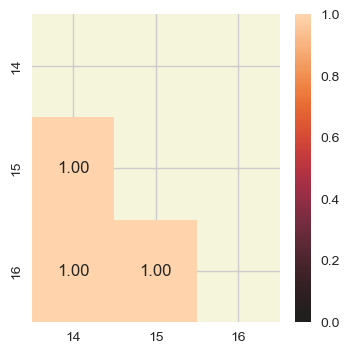

In [626]:
mask = np.triu(np.ones_like(df[feats].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df[feats].corr(), mask=mask, vmax=1, vmin=0, center=0,annot=True,fmt='.2f');

1.3. Biểu đồ đường thể hiện dữ liệu qua thời gian

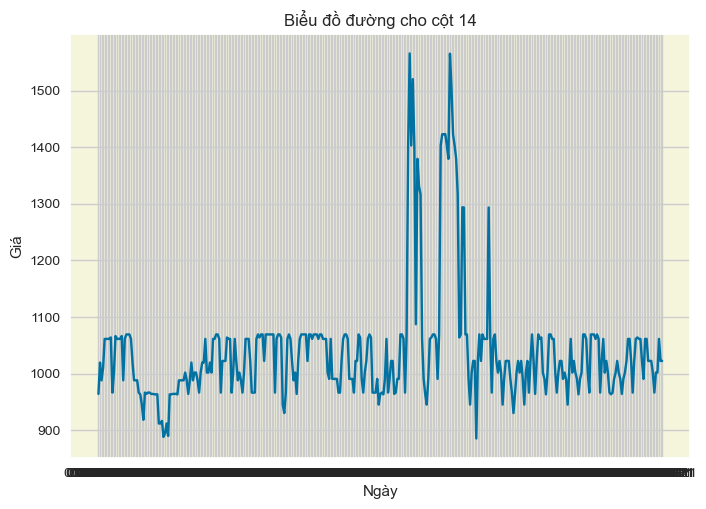

In [627]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['14'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 14')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

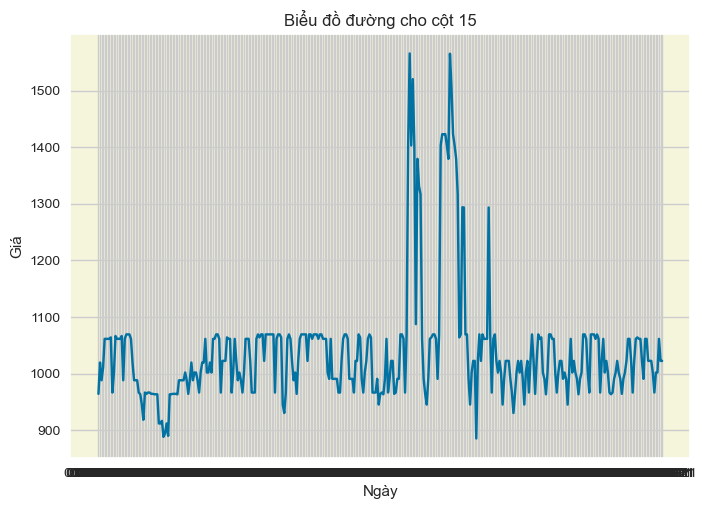

In [628]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['15'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 15')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

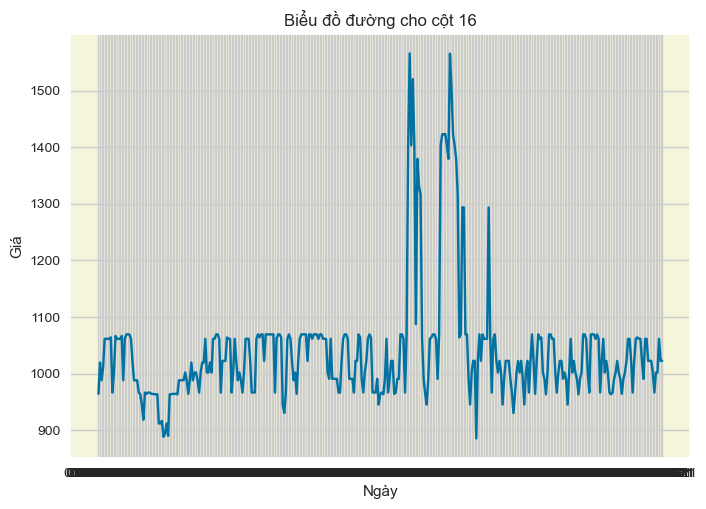

In [629]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['16'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 16')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

- Scale dữ liệu

In [630]:
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[feats]))

- Dữ liệu sau khi scale

In [631]:
X[:5]

array([[-0.72298405, -0.72306502, -0.72311218],
       [-0.19632568, -0.19639898, -0.1964422 ],
       [-0.49441622, -0.49449386, -0.49453931],
       [-0.28108625, -0.28116079, -0.28120464],
       [ 0.20176329,  0.20169578,  0.20165554]])

- Sử dụng phương pháp Elbow để xác định số cụm thông qua KMeans

c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\MSI\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less ch

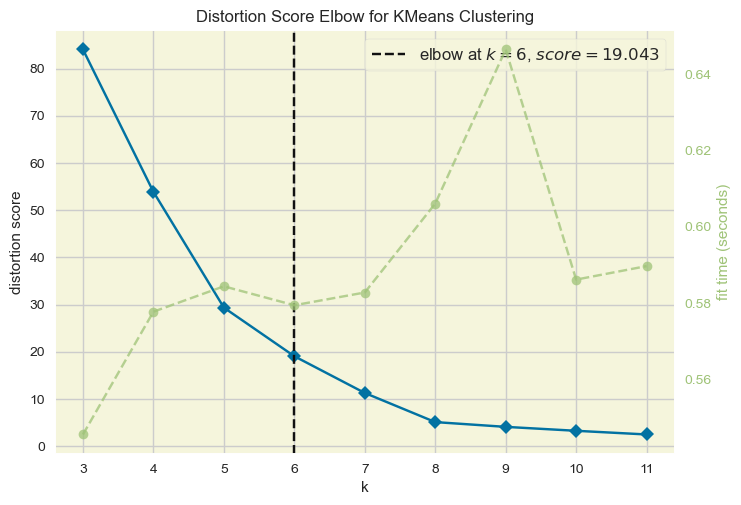

In [632]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(3,12))
Elbow_M.fit(X)
Elbow_M.show();

### 2. Sử dụng LSTM để dự đoán giá trị tương lai

In [633]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [634]:
feats = ['Ngày', '14', '15', '16']

In [635]:
df = df[feats]

In [636]:
df

,Ngày,14,15,16
0,01/01/2021,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4
3,01/04/2021,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5
...,...,...,...,...
360,27/12/2021,1002.1,1002.1,1002.1
361,28/12/2021,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6


- Chuyển format ngày

In [637]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

- Tạo số dữ liệu test bằng tháng 12

In [638]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

Biểu đồ thể hiện training và test trước khi dự đoán

- Biểu đồ thể hiện toàn bộ dữ liệu

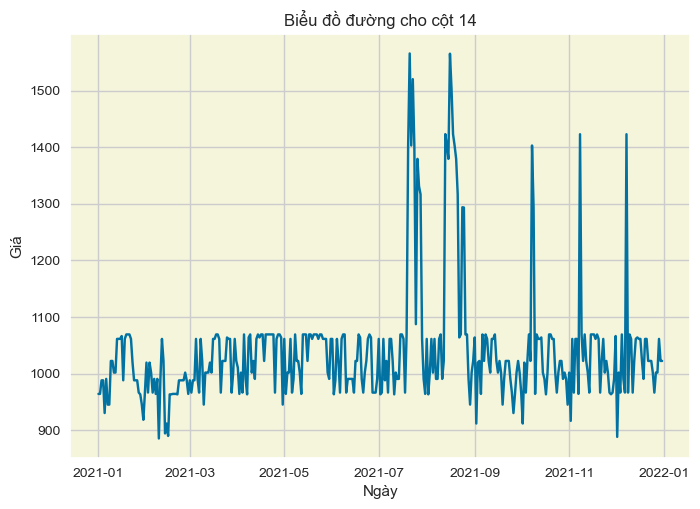

In [639]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['14'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 14')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

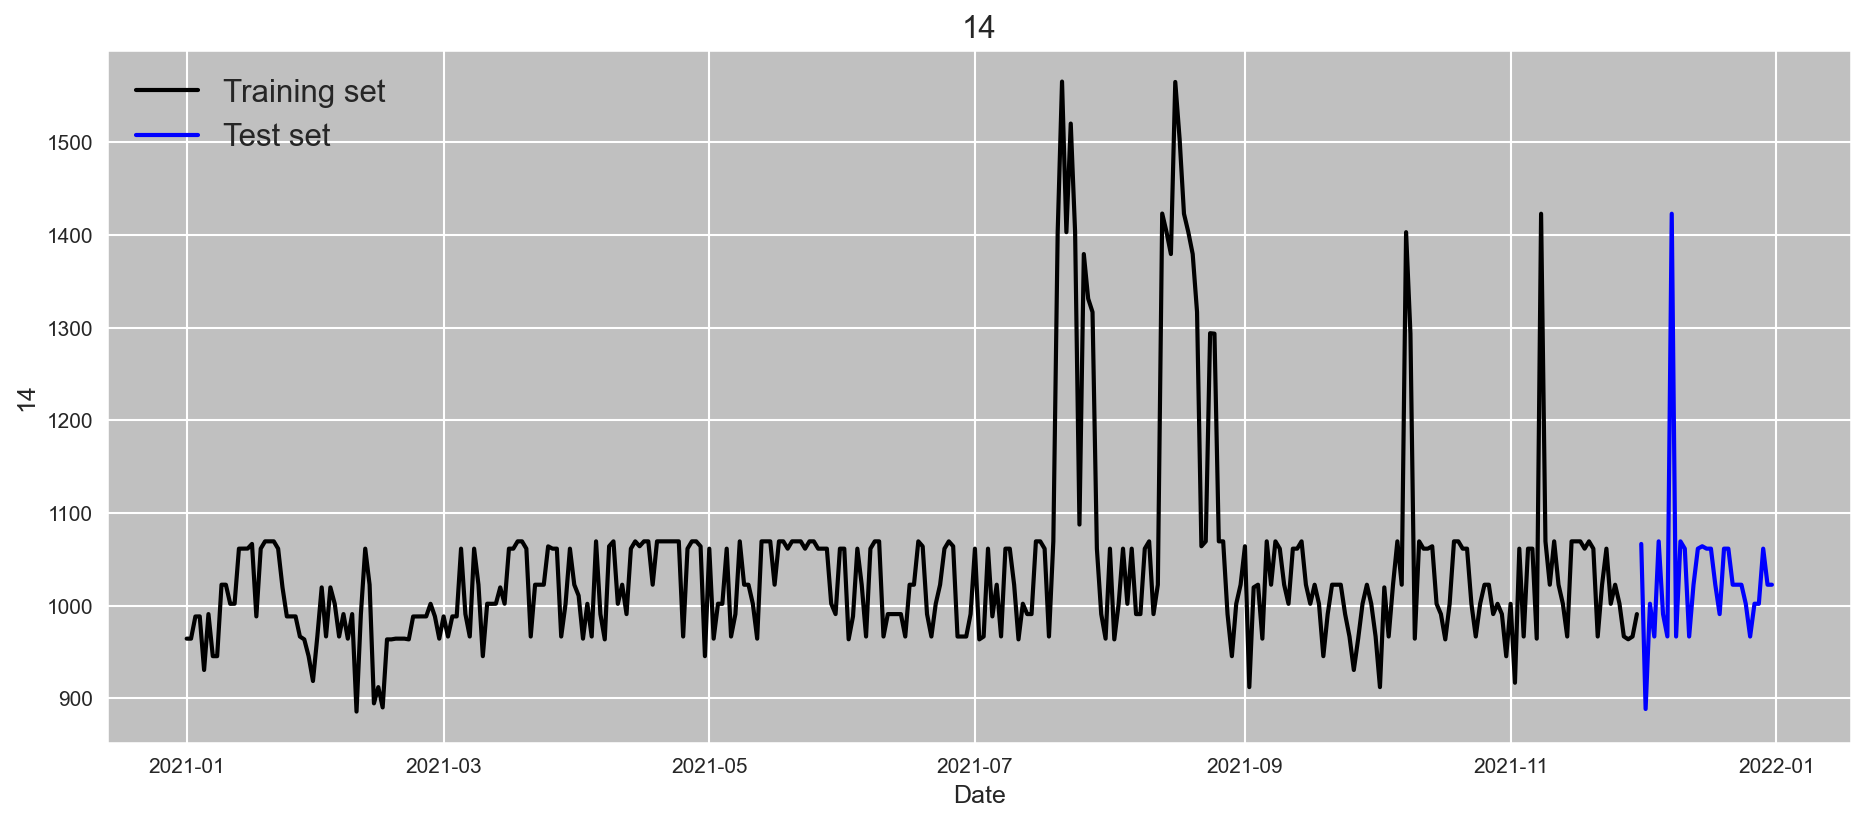

In [640]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'Silver'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['14'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['14'][-test_size:], color='blue', lw=2)
plt.title('14', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('14', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- Sử dụng MinMaxScaler để đưa dữ liệu về khoảng 0-1

In [641]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['14']])

MinMaxScaler()

- Chọn window_size = 10 tức là 10 ngày dự đoán cho 1 ngày tiếp theo

In [642]:
window_size = 10

- Tạo tập training data

In [643]:
train_data = df[['14']][:-test_size]
train_data = scaler.transform(train_data)

In [644]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

- Tạo tập test data

In [645]:
test_data = df[['14']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [646]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

- Chuyển đổi dữ liệu từ dataframe, series sang numpy array

In [647]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [648]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [649]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


- Khởi tạo model

In [650]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

- Tạo bộ siêu tham số: epochs=30 (lặp 30 lần)

In [651]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0923 - val_loss: 0.0597
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0741 - val_loss: 0.0399
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0452 - val_loss: 0.0153
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 - val_loss: 0.0185
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - val_loss: 0.0159
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0309 - val_loss: 0.0151
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0240 - val_loss: 0.0153
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - val_loss: 0.0158
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_loss: 0.0157
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0154
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0266 - val_loss: 0.0156
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0216 - val_l

- Dự đoán

In [652]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


In [653]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [654]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.017742527648806572
Test MAPE: 1.7772912569184152


In [655]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

- Vẽ biểu đồ sau khi đã dự đoán

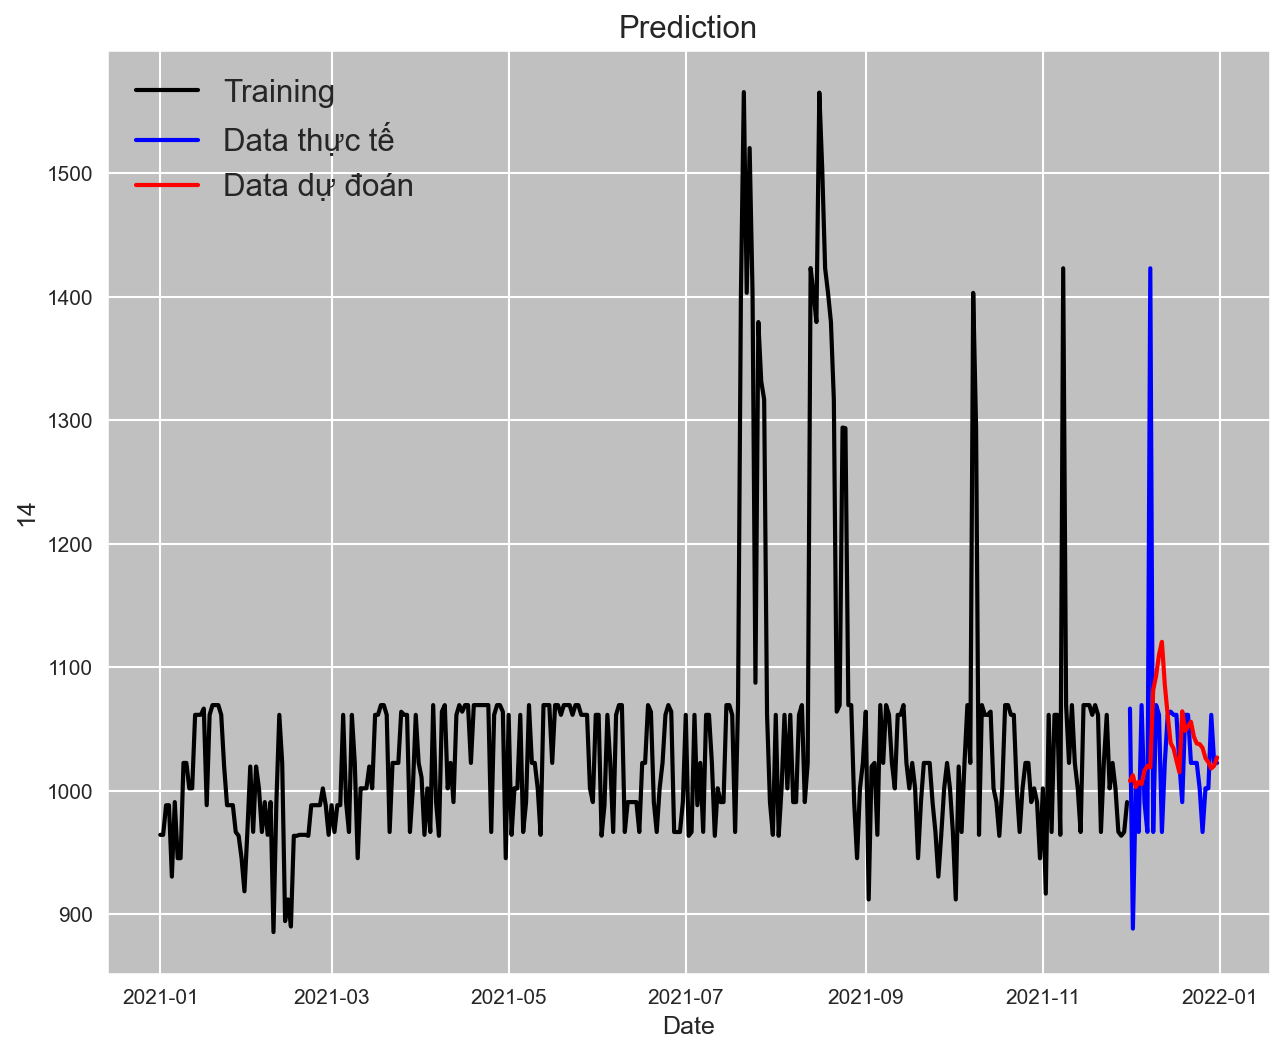

In [656]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'Silver'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('14', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

Cột 15

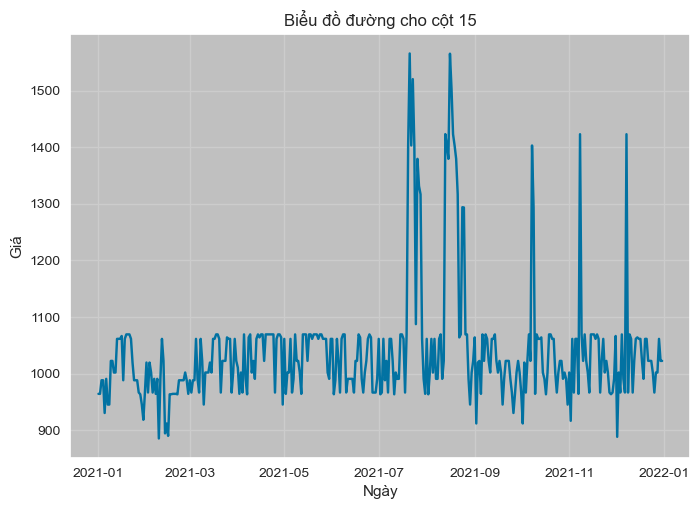

In [657]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['15'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 15')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

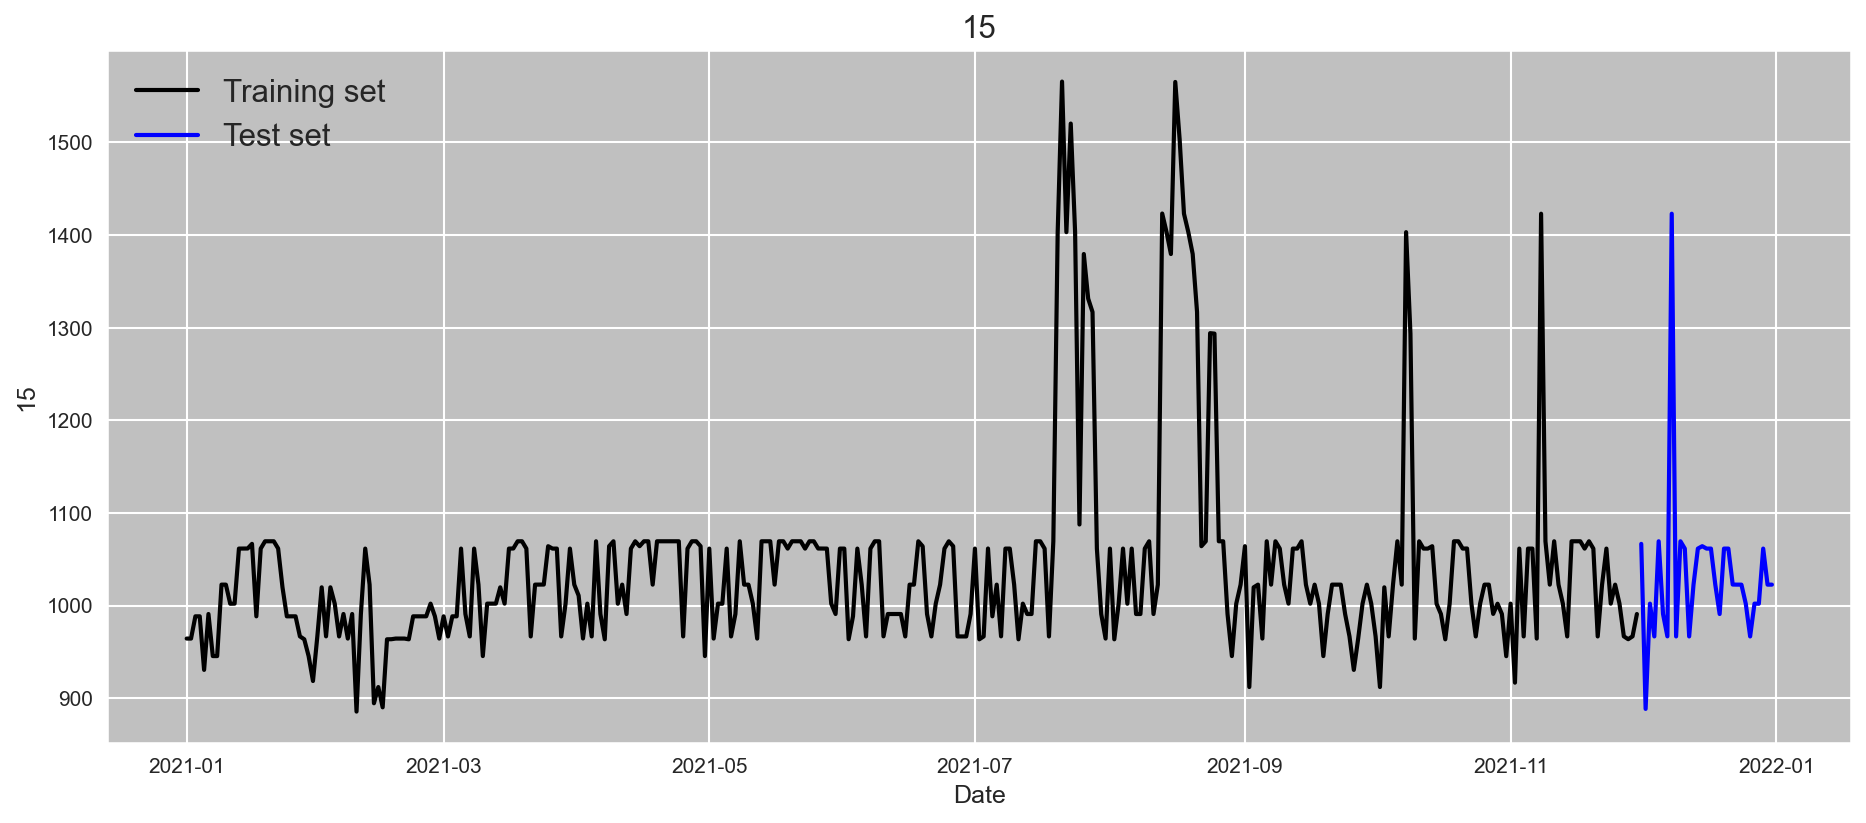

In [658]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'Silver'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['15'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['15'][-test_size:], color='blue', lw=2)
plt.title('15', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('15', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [659]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['15']])

MinMaxScaler()

In [660]:
window_size = 10

In [661]:
train_data = df[['15']][:-test_size]
train_data = scaler.transform(train_data)

In [662]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [663]:
test_data = df[['15']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [664]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [665]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [666]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [667]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


In [668]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [669]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0918 - val_loss: 0.0555
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0733 - val_loss: 0.0379
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0469 - val_loss: 0.0152
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - val_loss: 0.0169
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - val_loss: 0.0156
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0303 - val_loss: 0.0156
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - val_loss: 0.0154
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - val_loss: 0.0155
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0280 - val_loss: 0.0154
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - val_loss: 0.0160
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - val_loss: 0.0161
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - val_l

In [670]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


In [671]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [672]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.0228513702750206
Test MAPE: 2.283802651196828


In [673]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

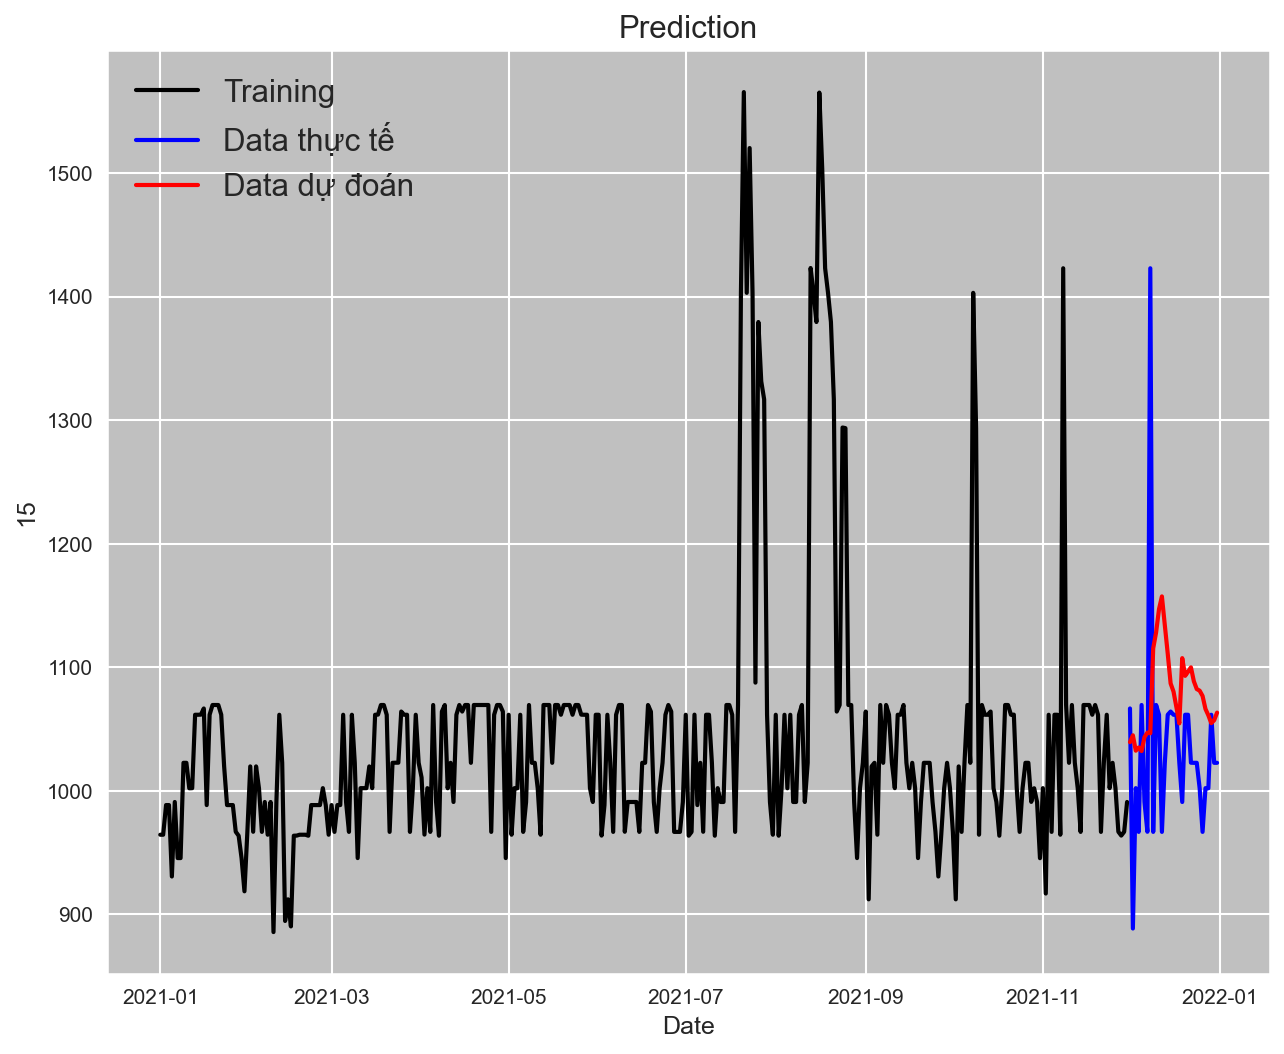

In [674]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'Silver'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('15', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

Cột 16

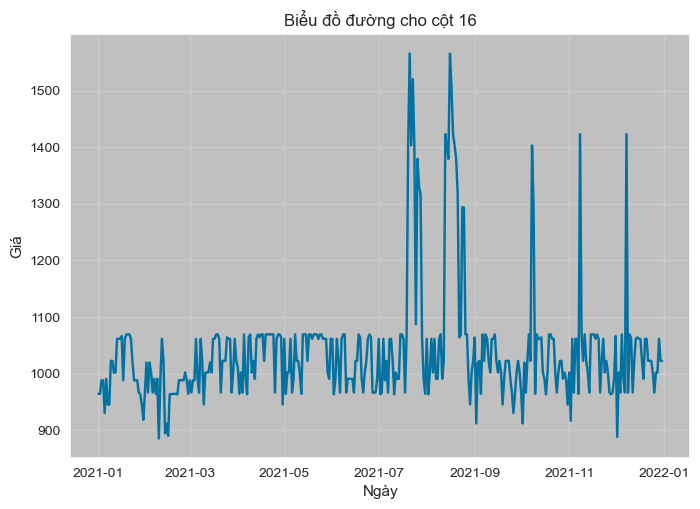

In [675]:
# Tạo biểu đồ đường bằng seaborn
sns.lineplot(x=df['Ngày'], y=df['16'], data=df)

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ đường cho cột 16')
plt.xlabel('Ngày')
plt.ylabel('Giá')

# Hiển thị biểu đồ
plt.show()

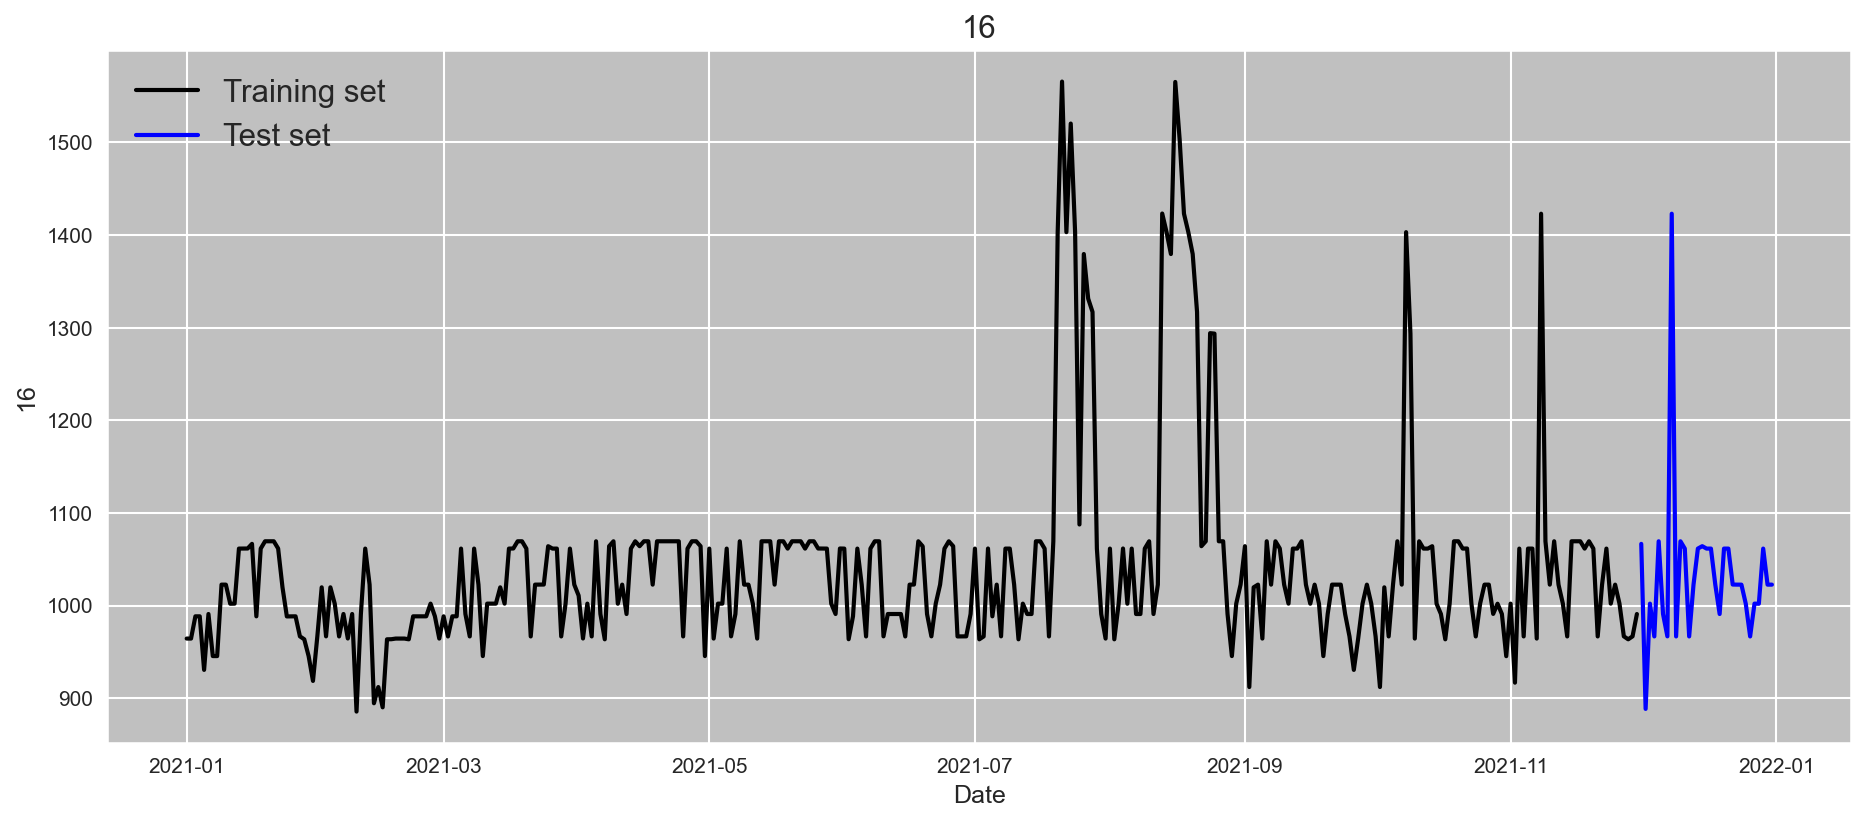

In [676]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'Silver'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['16'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['16'][-test_size:], color='blue', lw=2)
plt.title('16', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('16', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [677]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['16']])

MinMaxScaler()

In [678]:
window_size = 10

In [679]:
train_data = df[['16']][:-test_size]
train_data = scaler.transform(train_data)

In [680]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [681]:
test_data = df[['16']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [682]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [683]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [684]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [685]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


In [686]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [687]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0548 - val_loss: 0.0341
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0540 - val_loss: 0.0245
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0306 - val_loss: 0.0157
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221 - val_loss: 0.0155
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - val_loss: 0.0152
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 - val_loss: 0.0154
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0207 - val_loss: 0.0153
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - val_loss: 0.0164
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - val_loss: 0.0157
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0304 - val_loss: 0.0151
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - val_l

In [688]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [689]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [690]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.016878878697752953
Test MAPE: 1.5990737658314813


In [691]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

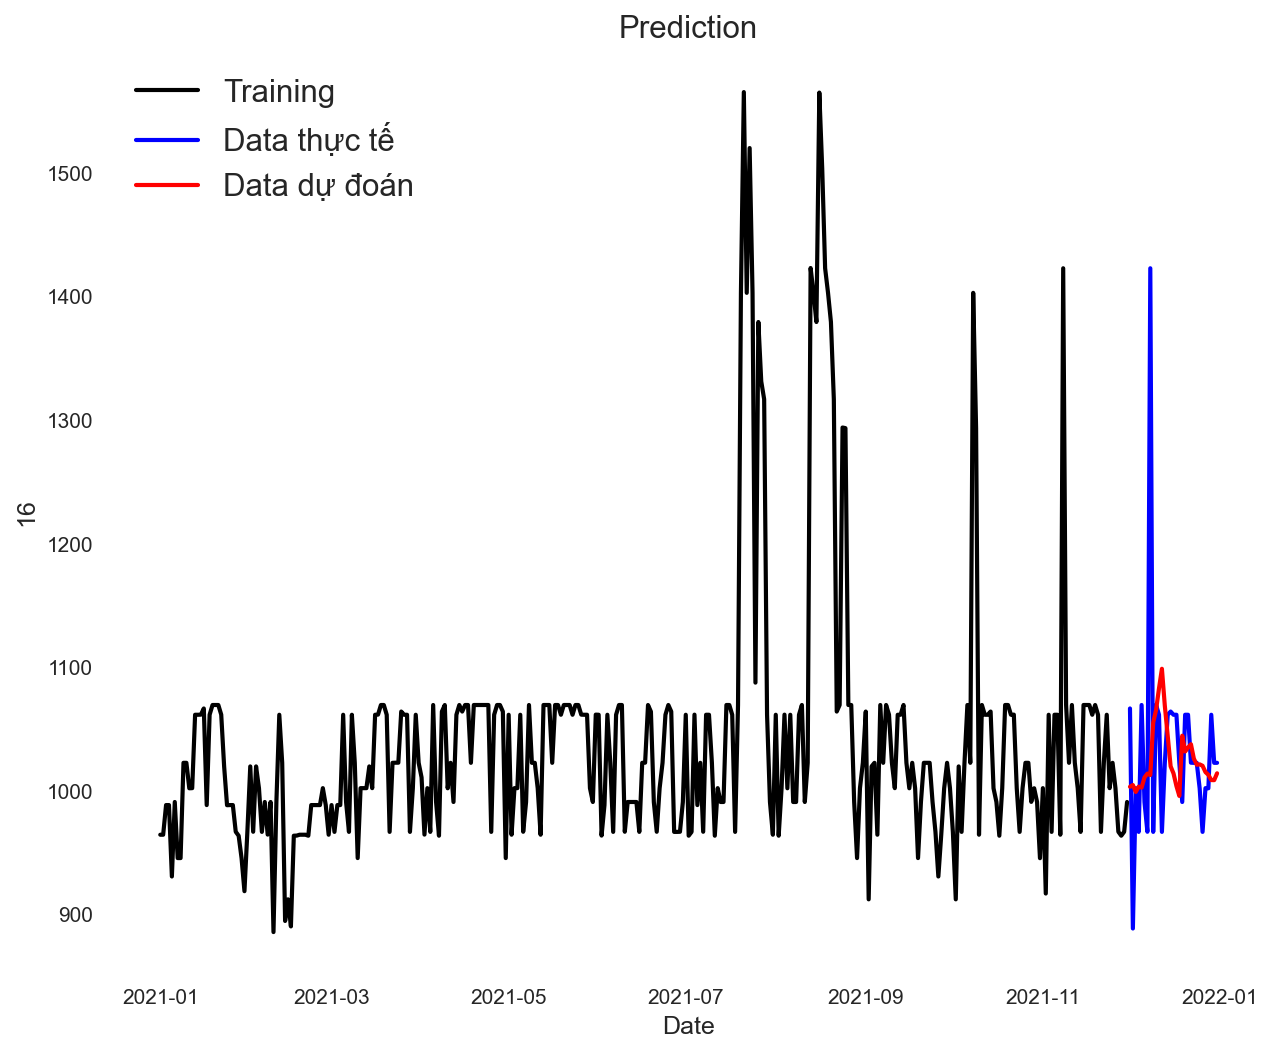

In [692]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('16', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

### 3. Kalman

In [693]:
data = df[['14', '15', '16']]

   filtered_1  filtered_2  filtered_3
0  966.035079  966.040652  966.040652
1  969.305237  969.321955  969.321955
2  977.480631  977.525213  977.525213
3  974.836656  974.853685  974.853685
4  958.629337  958.635841  958.635841


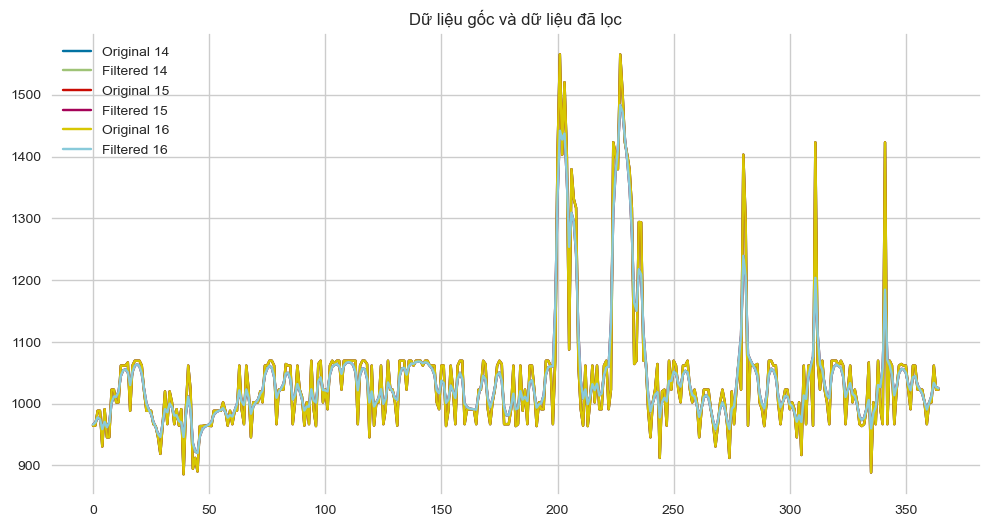

In [694]:
measurements = data.values
kf = KalmanFilter(initial_state_mean=measurements[0], n_dim_obs=measurements.shape[1])
state_means, state_covariances = kf.smooth(measurements)

filtered_data = pd.DataFrame(state_means, columns=[f'filtered_{i}' for i in range(1, measurements.shape[1] + 1)])
print(filtered_data.head())

plt.figure(figsize=(12, 6))
for i, column in enumerate(data.columns):
    plt.plot(data.index, data[column], label=f'Original {column}')
    plt.plot(data.index, filtered_data[f'filtered_{i+1}'], label=f'Filtered {column}')
plt.legend()
plt.title('Dữ liệu gốc và dữ liệu đã lọc')
plt.show()
